## Install Required Libraries

In [11]:
# install github branch feat/pytorch-detach from  git+https://github.com/gon-uri/detach_rocket

!pip install sktime --quiet
#!pip install  git+https://github.com/gon-uri/detach_rocket.git@feat/pytorch-detach --quiet
!pip install pyts --quiet
!pip install matplotlib --quiet
!pip install torch --quiet

## Download Dataset from UCR

In [1]:
import numpy as np
import sys
sys.path.append('..')

from detach_rocket.utils_datasets import fetch_ucr_dataset


# Download Dataset
dataset_name_list = ['ProximalPhalanxOutlineAgeGroup'] # PhalangesOutlinesCorrect ProximalPhalanxOutlineCorrect #Fordb
current_dataset = fetch_ucr_dataset(dataset_name_list[0])

## Prepare Dataset Matrices

In [2]:
# Create data matrices and remove possible rows with nans
print(f"Dataset Matrix Shape: ( # of instances , time series length )")
print(f" ")

# Train Matrix
X_train = current_dataset['data_train']

non_nan_mask_train = ~np.isnan(X_train).any(axis=1)
non_inf_mask_train = ~np.isinf(X_train).any(axis=1)
mask_train = np.logical_and(non_nan_mask_train,non_inf_mask_train)
X_train = X_train[mask_train]
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
y_train = current_dataset['target_train']
y_train = y_train[mask_train]
print(f"Train Shape: {X_train.shape}")

print(f" ")

# Test Matrix
X_test = current_dataset['data_test']
#print(f"Number of test instances: {len(X_test)}")

non_nan_mask_test = ~np.isnan(X_test).any(axis=1)
non_inf_mask_test = ~np.isinf(X_test).any(axis=1)
mask_test = np.logical_and(non_nan_mask_test,non_inf_mask_test)
X_test = X_test[mask_test]
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_test = current_dataset['target_test']
y_test = y_test[mask_test]
print(f"Test Shape: {X_test.shape}")

print(f" ")

# Number of classes
n_classes = len(np.unique(y_train))
print(f"Number of classes: {n_classes}")

# Convert y_train and y_test to start from 0
y_train = y_train - np.min(y_train)
y_test = y_test - np.min(y_test)
# Print class labels
print(f"Class labels: {np.unique(y_train)}")


Dataset Matrix Shape: ( # of instances , time series length )
 
Train Shape: (400, 1, 80)
 
Test Shape: (205, 1, 80)
 
Number of classes: 3
Class labels: [0 1 2]


## Train and Evaluate the Model

In [42]:
# Import RocketPytorch and training utils
from detach_rocket.detach_classes import RocketPytorch
from detach_rocket.utils_pytorch import get_feature_importance
from detach_rocket.utils_pytorch import train_model
from detach_rocket.utils_pytorch import compute_accuracy
from detach_rocket.utils_pytorch import prune_model_SFD

# Import torch 
import torch
from torch.utils.data import TensorDataset, DataLoader

# set device to cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(2)

# Define input channels 
c_in = X_train.shape[1]

# If binary classification, c_out = 1, else c_out = n_classes
if n_classes == 2:
    c_out = 1
else:
    c_out = n_classes

seq_len = X_train.shape[2]

# Define number of kernels
num_kernels = 1000

# Define L2 regularization weight
L2_regularization_weight = 1e-3

# Define patience for early stopping
patience = 10

# Define batch size
batch_size = 2048

# Define number of epochs
n_epochs = 100

# Create model object
PytorchRocketModel = RocketPytorch(c_in,c_out,seq_len,num_kernels)
PytorchRocketModel = PytorchRocketModel.float()

# Create TensorDatasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [43]:
# Train model
train_losses_full_model, test_losses_full_model, total_epochs_full = train_model(PytorchRocketModel, train_data, test_data, n_epochs, batch_size, patience,L2_regularization_weight)

Epoch: 1 	Training Loss: 1.098612 	Validation Loss: 1.975847
Validation loss decreased (inf --> 1.975847).  Saving model ...
Epoch: 2 	Training Loss: 0.625267 	Validation Loss: 2.569419
EarlyStopping counter: 1 out of 20
Epoch: 3 	Training Loss: 0.632482 	Validation Loss: 2.810069
EarlyStopping counter: 2 out of 20
Epoch: 4 	Training Loss: 0.665013 	Validation Loss: 2.685728
EarlyStopping counter: 3 out of 20
Epoch: 5 	Training Loss: 0.660938 	Validation Loss: 2.331518
EarlyStopping counter: 4 out of 20
Epoch: 6 	Training Loss: 0.622998 	Validation Loss: 1.863570
Validation loss decreased (1.975847 --> 1.863570).  Saving model ...
Epoch: 7 	Training Loss: 0.561988 	Validation Loss: 1.377223
Validation loss decreased (1.863570 --> 1.377223).  Saving model ...
Epoch: 8 	Training Loss: 0.487953 	Validation Loss: 0.963511
Validation loss decreased (1.377223 --> 0.963511).  Saving model ...
Epoch: 9 	Training Loss: 0.416624 	Validation Loss: 0.706866
Validation loss decreased (0.963511 --> 

In [44]:
# Force to reload all modules from utils_pytorch
import importlib
importlib.reload(sys.modules['detach_rocket.utils_pytorch'])
from detach_rocket.utils_pytorch import compute_accuracy
from detach_rocket.utils_pytorch import get_feature_importance
from detach_rocket.utils_pytorch import prune_model_SFD
from detach_rocket.utils_pytorch import train_model

In [45]:
# Load best model
PytorchRocketModel.load_state_dict(torch.load('checkpoint.pt'))

# Compute accuracy
train_accuracy_full_model, test_accuracy_full_model = compute_accuracy(PytorchRocketModel, train_data, test_data, batch_size)

# Get feature importance
feature_importance_full_model = get_feature_importance(PytorchRocketModel)

print(f"Train accuracy: {train_accuracy_full_model}")
print(f"Test accuracy: {test_accuracy_full_model}")

Train accuracy: 0.9325
Test accuracy: 0.8682926829268293


In [46]:
# Percentage of features to drop
drop_percentage = 0.2

# Verbose
verbose = True

# Number of epochs after pruning
n_epochs_SFD = 10

# Patience after pruning
patience_SFD = 5

# Number of pruning iterations
n_pruning_iterations = 10

In [47]:
import shutil

# Define lists to store accuracy and feature importance
train_accuracy_list = []
test_accuracy_list = []
feature_importance_list = []

# Best validation loss
best_loss_min = np.Inf

# Best model iteration
best_model_iteration = 0

# Prune model n_pruning_iterations times
for i in range(n_pruning_iterations):

    # Print iteration number
    print(f" ")
    print(f"Iteration number: {i}")
    print(f" ")

    # Prune model
    feature_importance = prune_model_SFD(PytorchRocketModel, drop_percentage=drop_percentage, verbose=verbose)

    # Train model after pruning
    train_losses, test_losses, total_epochs = train_model(PytorchRocketModel, train_data, test_data, n_epochs_SFD, batch_size, patience_SFD,L2_regularization_weight)

    # Append accuracy and feature importance to lists
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    feature_importance_list.append(feature_importance)

    # Save Best overall model if validation loss has decreased
    # (copy checkpoint.pt to checkpoint_best_pruned.pt)
    min_val_loss = np.min(test_losses)
    if min_val_loss < best_loss_min:
        # Update best loss
        best_loss_min = min_val_loss
        shutil.copyfile('checkpoint.pt', 'checkpoint_best_pruned.pt')
        # Update best model iteration
        best_model_iteration = i
    
    # Load best model in that iteration
    PytorchRocketModel.load_state_dict(torch.load('checkpoint.pt'))

    # Compute accuracy
    train_accuracy, test_accuracy = compute_accuracy(PytorchRocketModel, train_data, test_data, batch_size)

 
Iteration number: 0
 
Number of features pruned: 408
Number of features kept: 1592
Percentage of zeros in weight matrix: 0.204 %
Epoch: 1 	Training Loss: 0.180541 	Validation Loss: 0.427357
Validation loss decreased (inf --> 0.427357).  Saving model ...
Epoch: 2 	Training Loss: 0.209761 	Validation Loss: 0.417101
Validation loss decreased (0.427357 --> 0.417101).  Saving model ...
Epoch: 3 	Training Loss: 0.184272 	Validation Loss: 0.397639
Validation loss decreased (0.417101 --> 0.397639).  Saving model ...
Epoch: 4 	Training Loss: 0.157280 	Validation Loss: 0.404783
EarlyStopping counter: 1 out of 5
Epoch: 5 	Training Loss: 0.169261 	Validation Loss: 0.410387
EarlyStopping counter: 2 out of 5
Epoch: 6 	Training Loss: 0.172973 	Validation Loss: 0.403144
EarlyStopping counter: 3 out of 5
Epoch: 7 	Training Loss: 0.155578 	Validation Loss: 0.405525
EarlyStopping counter: 4 out of 5
Epoch: 8 	Training Loss: 0.145307 	Validation Loss: 0.418449
EarlyStopping counter: 5 out of 5
Early sto

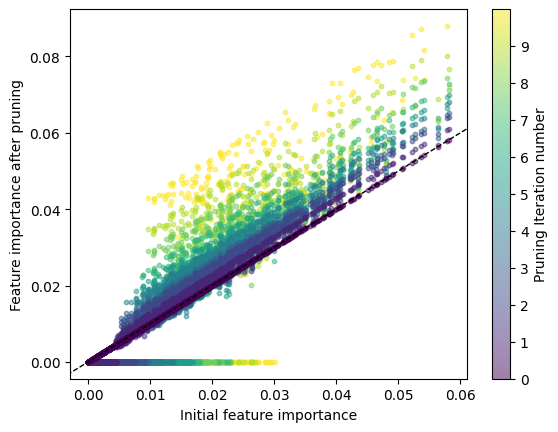

In [61]:
# Plot full model feature importance vs feature importance after pruning for each iteration
# Color points according to iteration number

# Define color map
cmap = plt.get_cmap('viridis')

# Define number of iterations
n_iterations = len(feature_importance_list)

# Define color list
color_list = [cmap(i) for i in np.linspace(1, 0, n_iterations)]

# Plot
for i in range(n_iterations):

    plt.scatter(feature_importance_full_model,feature_importance_list[n_iterations-i-1], s=10, color=color_list[i],alpha=0.5)
    
# plot diagonal line
xpoints = ypoints = plt.ylim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)


# Change colorbar label and value range to match number of iterations
cbar = plt.colorbar()
cbar.set_label('Pruning Iteration number')
cbar.set_ticks(np.arange(n_iterations)/n_iterations)
cbar.set_ticklabels(np.arange(n_iterations))


plt.xlabel('Initial feature importance')
plt.ylabel('Feature importance after pruning')
plt.show()

In [193]:
# Esto lo habia empezado a escribir para cuando haya que selencionar kernels a partir de features

# Create a kernel mask
kernel_mask_list = []
for i in range(int(n_features/2)):
    # If two consecutive features are dropped, drop the corresponding kernel
    if feature_mask[2*i] == False and feature_mask[2*i+1] == False:
        kernel_mask_list.append(False)
    else:
        kernel_mask_list.append(True)

# Drop kernels
